# Data Driven: Pump It Up (2/3)

**Vilhelm Stiernstedt & Camillo Baratta**
<br>
** Date: 14/03/2018**

** Instructions **
<br>
Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.
<br>
<br>
** Goal **
<br>
Your goal is to predict the operating condition of a waterpoint for each record in the dataset.
The labels in this dataset are simple. There are three possible values:

- functional - the waterpoint is operational and there are no repairs needed
- functional needs repair - the waterpoint is operational, but needs repairs
- non functional - the waterpoint is not operational

**Plan**
1. Import libraries
2. Import data
3. Data description
4. Feature analysis
5. Data cleaning
    - Impute missing values
    - Outlier treatment
6. Feature engineering
    - Transformation
    - Binning
    - New features
7. Feature selection
    - Drop irrelevant features
8. Modelling Preparation
    - One-hot encoding
    - Test/train split
9. Modelling
    - Randomforest model
    - Light GBM
    - KNN
    - LDA
    - LR-OVR (OneVsAll)
    - Stacked Model
10. Submission

<br>
** Notebooks used in project:**
<br>
The different steps are distrubuted over 3 notebooks:
1. Data Analysis - step 1-4 (Pump_Data_Analysis)
2. Data Preparation - steps 5-8 (Pump_Data_Preparation)
3. Data Modelling - steps 9-10 (Pump_Models)

## Import Libaries & Settings

In [1]:
# Import libaries
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns
import warnings

# Pandas settings
pd.set_option('display.max_columns', 100)

# Plot settings
%matplotlib inline

# Warning settings
# suspend matplotlib warnings
warnings.filterwarnings("ignore")

## Import Data
1. Load csv files:
    - train_values
    - train_labels
    - test_values
2. Merge train_values and train_labels into **train** - use this df for all data analysis.
3. Merge train with test_values into **all_data** - use this df for all cleaning and then split train and test before modelling.
3. Write files to csv for storage.

In [2]:
# Data Processing
# Import data
train_values = pd.read_csv("data/train_set_values.csv", sep=",")
train_labels = pd.read_csv("data/train_set_labels.csv", sep=",")
test = pd.read_csv("data/test.csv", sep=",")

# Merge train with train_labels
train = train_values.merge(train_labels, on='id', how='inner')

# Merge train with test_values
all_data = train.append(test)

# Set  id index
all_data.set_index('id', inplace=True)
train_labels.set_index('id', inplace=True)
train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

# Write to csv
#train.to_csv('data/train.csv', sep=',')
#test.to_csv('data/test.csv', sep=',')
#all_data.to_csv('data/all_data.csv', sep=',')

### Transform data types
date_recorded -> string to datetime

In [3]:
# Transform dtypes
# Numerical to datetime (Year-MM-DD)
all_data.date_recorded = pd.to_datetime(all_data.date_recorded,
                                        errors='ignore',
                                        format='%Y-%m-%d')

train.date_recorded = pd.to_datetime(train.date_recorded,
                                     errors='ignore',
                                     format='%Y-%m-%d')

test.date_recorded = pd.to_datetime(test.date_recorded,
                                    errors='ignore',
                                    format='%Y-%m-%d')

## 5. Data Cleaning 
Go through each group of features and perform the following operations:
1. Missing values imputation
2. Outlier treatment

### Missing values imputations
All imputation is done with df: all_data

1. NaN imputation
2. Incorrect zero values

Note: Prior to 2. the data was analysed thoroughly to define which zero values needed to be treated and which not.

### NaN imputation

In [4]:
all_nan = all_data.drop(['status_group'], axis=1).isnull().sum()
all_nan[all_nan > 0]

funder                4504
installer             4532
permit                3793
public_meeting        4155
scheme_management     4846
scheme_name          35258
subvillage             470
dtype: int64

In [5]:
#7 variables were found to have null-values. scheme_name had the most by far.

#### subvillage

1. Impute all NaNs to 'unknown'
2. Impute 'unknown' to all subvillages with len(str) < 3 

In [6]:
# NaNs count
all_data.subvillage.isnull().sum()

470

In [7]:
# Impute NaNs with unknown
all_data.subvillage.fillna(value='Unknown', inplace=True)

In [8]:
# Count nr of longitude equal zero again
all_data.loc[(all_data.subvillage.str.len()) < 3, 'subvillage'].count()

892

In [9]:
# impute subvillages with string len of 1 to unknown
all_data.loc[(all_data.subvillage.str.len()) < 3, 'subvillage'] = 'Unknown'

In [10]:
# check that no remains
all_data[(all_data.subvillage.str.len()) < 3].subvillage.count()

0

#### scheme_name

In [11]:
# NaNs count
all_data.scheme_name.isnull().sum()

35258

In [12]:
# Impute NaNs with unknown
all_data.scheme_name.fillna(value='Unknown', inplace=True)

#### scheme_management

In [13]:
# NaNs count
all_data.scheme_management.isnull().sum()

4846

In [14]:
# Impute NaNs with unknown
all_data.scheme_management.fillna(value='Unknown', inplace=True)

#### installer

In [15]:
# NaNs count
all_data.installer.isnull().sum()

4532

In [16]:
# Impute NaNs with unknown
all_data.installer.fillna(value='Unknown', inplace=True)

#### funder

In [17]:
# NaNs count
all_data.funder.isnull().sum()

4504

In [18]:
# Impute NaNs with unknown
all_data.funder.fillna(value='Unknown', inplace=True)

#### public_meeting

In [19]:
# NaNs count
all_data.public_meeting.isnull().sum()

4155

In [20]:
# Impute NaNs with unknown
all_data.public_meeting.fillna(value='Unknown', inplace=True)

#### permit

In [21]:
# NaNs count
all_data.permit.isnull().sum()

3793

In [22]:
# Impute NaNs with False
all_data.permit.fillna(value='False', inplace=True)

#### scheme_management

In [23]:
# NaNs count
all_data.scheme_management.isnull().sum()

0

In [24]:
# Impute NaNs with unknown
all_data.scheme_management.fillna(value='Unknown', inplace=True)

### Check that all NaNs are zero 

In [25]:
# Check that all NaNs are zero 
all_nan = all_data.drop(['status_group'], axis=1).isnull().sum()
all_nan[all_nan > 0]

Series([], dtype: int64)

### zero-value imputation

#### longitude

1. Convert zeros to NaNs.
2. Impute NaNs longitude per subvillage mean
3. For remaning, impute longitude per ward mean
4. For remaning, impute longitude per lga mean

Note: we chose the approach to gain the most useful imputation without getting lost in too detailed data (e.g. lga). this approach was based on our analysis of the data (i.e. understanding the meaning of lga, ward, subvillage)

In [26]:
# Count nr of longitude equal zero
all_data.loc[all_data.longitude == 0, 'longitude'].count()

2269

In [27]:
# convert all zeros to NaN
all_data.loc[all_data.longitude == 0, 'longitude'] = np.nan

In [28]:
# check for NaNs
all_data.longitude.isnull().sum()

2269

In [29]:
# impute NaNs longitude per subvillage mean
all_data.longitude.fillna(all_data.groupby('subvillage').longitude.transform('mean'), inplace=True)

In [30]:
# check for NaNs
all_data.longitude.isnull().sum()

1410

In [31]:
# impute NaNs longitude per ward mean
all_data.longitude.fillna(all_data.groupby('ward').longitude.transform('mean'), inplace=True)

In [32]:
# check for NaNs
all_data.longitude.isnull().sum()

37

In [33]:
# impute NaNs longitude per lga mean
all_data.longitude.fillna(all_data.groupby('lga').longitude.transform('mean'), inplace=True)

In [34]:
# check for NaNs
all_data.longitude.isnull().sum()

0

In [35]:
# Overall info
all_data.longitude.describe()

count    74250.000000
mean        35.121277
std          2.580671
min         29.607122
25%         33.303138
50%         34.945507
75%         37.184269
max         40.345193
Name: longitude, dtype: float64

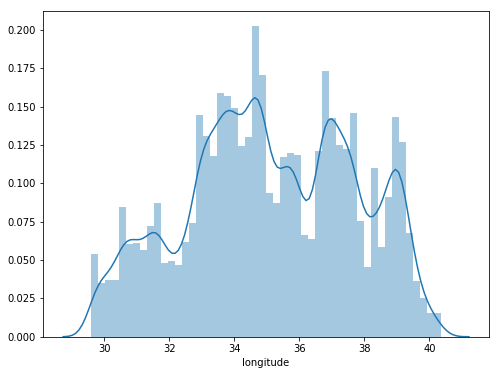

In [36]:
# plot new distrubition of longitude  -> looks good
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(all_data.longitude);

#### latitude

1. Convert zeros to NaNs.
2. Impute NaNs latitude per subvillage mean
3. For remaning, impute latitude per ward mean
4. For remaning, impute latitude per lga mean

In [37]:
# Count nr of latitude equal zero
all_data.loc[all_data.latitude > -1.1, 'latitude'].count()

2417

In [38]:
# convert all zeros to NaN
all_data.loc[all_data.latitude > -1.1, 'latitude'] = np.nan

In [39]:
# check for NaNs
all_data.latitude.isnull().sum()

2417

In [40]:
# impute NaNs latitude per subvillage mean
all_data.latitude.fillna(all_data.groupby('subvillage').latitude.transform('mean'), inplace=True)

In [41]:
# check for NaNs
all_data.latitude.isnull().sum()

1509

In [42]:
# impute NaNs latitude per ward mean
all_data.latitude.fillna(all_data.groupby('ward').latitude.transform('mean'), inplace=True)

In [43]:
# check for NaNs
all_data.latitude.isnull().sum()

37

In [44]:
# impute NaNs latitude per lga mean
all_data.latitude.fillna(all_data.groupby('lga').latitude.transform('mean'), inplace=True)

In [45]:
# check for NaNs
all_data.latitude.isnull().sum()

0

In [46]:
# Overall info
all_data.latitude.describe()

count    74250.000000
mean        -5.843317
std          2.782797
min        -11.649440
25%         -8.531748
50%         -5.098763
75%         -3.376283
max         -1.100277
Name: latitude, dtype: float64

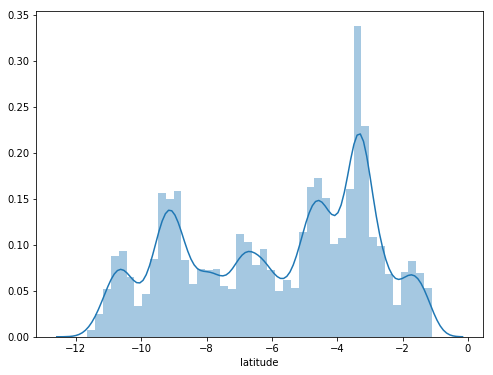

In [47]:
# plot new distrubition of latitude  -> looks good
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(all_data.latitude);

#### gps_height

1. Convert zeros to NaNs
2. Concat latitude and longitude to create new variable latlong
3. Use gps_height mean for latlong 
4. For remaining use, use gps_height mean for subvillage
5. For remaining use, use gps_height mean for ward
6. For remaining use, use gps_height mean for lga

In [48]:
# zero values
all_data[all_data.gps_height == 0].gps_height.count()

25649

In [49]:
# convert all zeros to NaN
all_data.loc[all_data.gps_height == 0, 'gps_height'] = np.nan

In [50]:
# check for NaNs
all_data.gps_height.isnull().sum()

25649

In [51]:
# gps_height
# Merge latitude and longitude into new variable, using only 2 decimals
all_data['latlong'] = all_data.latitude.round(2).map(str) + "-" + all_data.longitude.round(2).map(str)
all_data.latlong.head()

id
69572     -9.86-34.94
8776       -2.15-34.7
34310     -3.82-37.46
67743    -11.16-38.49
19728     -1.83-31.13
Name: latlong, dtype: object

In [52]:
# impute NaNs gps_height per latlong mean
all_data.gps_height.fillna(all_data.groupby('latlong').gps_height.transform('mean'), inplace=True)

In [53]:
# check for NaNs -> just fill anything, too granular
all_data.gps_height.isnull().sum()

25433

In [54]:
# impute NaNs gps_height per subvillage mean
all_data.gps_height.fillna(all_data.groupby('subvillage').gps_height.transform('mean'), inplace=True)

In [55]:
# check for NaNs
all_data.gps_height.isnull().sum()

19013

In [56]:
# impute NaNs gps_height per ward mean
all_data.gps_height.fillna(all_data.groupby('ward').gps_height.transform('mean'), inplace=True)

In [57]:
# check for NaNs
all_data.gps_height.isnull().sum()

2209

In [58]:
# impute NaNs gps_height per lga mean
all_data.gps_height.fillna(all_data.groupby('lga').gps_height.transform('mean'), inplace=True)

In [59]:
# check for NaNs
all_data.gps_height.isnull().sum()

114

In [60]:
# impute NaNs gps_height per region median
all_data.gps_height.fillna(all_data.groupby('region').gps_height.transform('median'), inplace=True)

In [61]:
# check for NaNs
all_data.gps_height.isnull().sum()

0

In [62]:
all_data.gps_height.describe()

count    74250.000000
mean      1038.288904
std        539.430995
min        -90.000000
25%        687.500000
50%       1115.000000
75%       1420.000000
max       2777.000000
Name: gps_height, dtype: float64

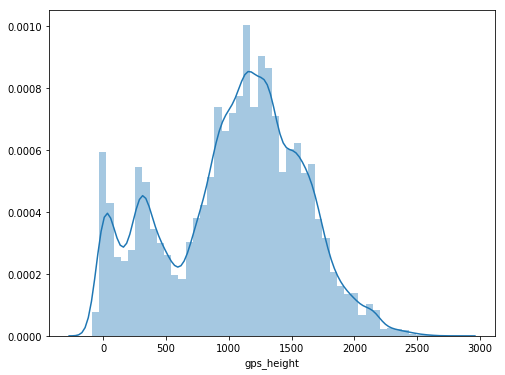

In [63]:
# plot new distrubition of gps_height -> looks good
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(all_data.gps_height);

#### construction_year
We assume that water points have been constructed in areas around similiar times by different scheme managements. Thus we will use the following strategy:

1. Convert all values below 1960 to NaNs
2. Impute all NaNs by taking the mean subvillage and scheme_management construction year.
3. For remaining, impute by taking the mean ward and scheme_management construction year.
4. For remaining, mpute by taking the mean lga and scheme_management construction year.
5. For remaining, impute by taking the mean region and scheme_management construction year.
6. For remaining, impute by taking the only mean scheme_management construction year.
7. For remaining, impute by taking the only mean subvillage construction year.
8. For remaining, impute by taking the only mean ward construction year.
9. For remaining, impute by taking the only mean lga construction year.

In [64]:
# Count nr of construction years less than 1960 
all_data.loc[all_data.construction_year < 1960, 'construction_year'].count()

25969

In [65]:
# convert all zeros to NaN
all_data.loc[all_data.construction_year < 1960, 'construction_year'] = np.nan

In [66]:
# check for NaNs
all_data.construction_year.isnull().sum()

25969

In [67]:
# impute NaNs construction_year per subvillage and scheme_management mean
all_data.construction_year.fillna(all_data.groupby(['subvillage', 'scheme_management'])\
                                  .construction_year.transform('mean'), inplace=True)

In [68]:
# check for NaNs
all_data.construction_year.isnull().sum()

20208

In [69]:
# impute NaNs construction_year per ward and scheme_management mean
all_data.construction_year.fillna(all_data.groupby(['ward', 'scheme_management'])\
                                  .construction_year.transform('mean'), inplace=True)

In [70]:
# check for NaNs
all_data.construction_year.isnull().sum()

5278

In [71]:
# impute NaNs construction_year per lga and scheme_management mean
all_data.construction_year.fillna(all_data.groupby(['lga', 'scheme_management'])\
                                  .construction_year.transform('mean'), inplace=True)

In [72]:
# check for NaNs
all_data.construction_year.isnull().sum()

870

In [73]:
# impute NaNs construction_year per region and scheme_management mean
all_data.construction_year.fillna(all_data.groupby(['region', 'scheme_management'])\
                                  .construction_year.transform('mean'), inplace=True)

In [74]:
# check for NaNs
all_data.construction_year.isnull().sum()

169

In [75]:
# impute NaNs construction_year per scheme_management mean
all_data.construction_year.fillna(all_data.groupby(['scheme_management'])\
                                  .construction_year.transform('mean'), inplace=True)

In [76]:
# check for NaNs
all_data.construction_year.isnull().sum()

0

In [77]:
all_data.construction_year.describe()

count    74250.000000
mean      1996.869508
std         10.694054
min       1960.000000
25%       1991.625000
50%       1998.370968
75%       2005.928571
max       2013.000000
Name: construction_year, dtype: float64

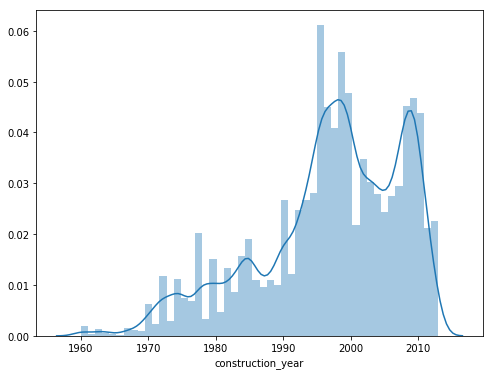

In [78]:
# plot new distrubition of construction_year -> looks okay
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(all_data.construction_year);

In [79]:
# See if there is any constructions years that are newer than date_recorded
all_data[(all_data.date_recorded.dt.year - all_data.construction_year) < 0].construction_year.count()

224

In [80]:
# Reimpute these records for constuction date -> date_recorded - 1
all_data.loc[(all_data.date_recorded.dt.year - all_data.construction_year) < 0,
             'construction_year'] = all_data.date_recorded.dt.year - 1

### population

1. Convert zeros to NaNs
2. Impute use population mean for subvillage
3. For remaining use mean for ward
4. For remaining use mean for lga
5. For remaining use mean for region

In [81]:
# Count nr of population equal zero
all_data.loc[all_data.population == 0, 'population'].count()

26834

In [82]:
# convert all zeros to NaN
all_data.loc[all_data.population == 0, 'population'] = np.nan

In [83]:
# check for NaNs
all_data.population.isnull().sum()

26834

In [84]:
# impute NaNs construction_year per subvillage
all_data.population.fillna(all_data.groupby(['subvillage']).population.transform('mean'), inplace=True)

In [85]:
# check for NaNs
all_data.population.isnull().sum()

19326

In [86]:
# impute NaNs construction_year per ward
all_data.population.fillna(all_data.groupby(['ward']).population.transform('mean'), inplace=True)

In [87]:
# check for NaNs
all_data.population.isnull().sum()

2351

In [88]:
# impute NaNs construction_year per lga
all_data.population.fillna(all_data.groupby(['lga']).population.transform('mean'), inplace=True)

In [89]:
# check for NaNs
all_data.population.isnull().sum()

114

In [90]:
# impute NaNs construction_year per region
all_data.population.fillna(all_data.groupby(['region']).population.transform('mean'), inplace=True)

In [91]:
# check for NaNs
all_data.population.isnull().sum()

0

In [92]:
all_data.population.describe()

count    74250.000000
mean       313.160913
std        492.218041
min          1.000000
25%         80.000000
50%        234.479361
75%        380.436937
max      30500.000000
Name: population, dtype: float64

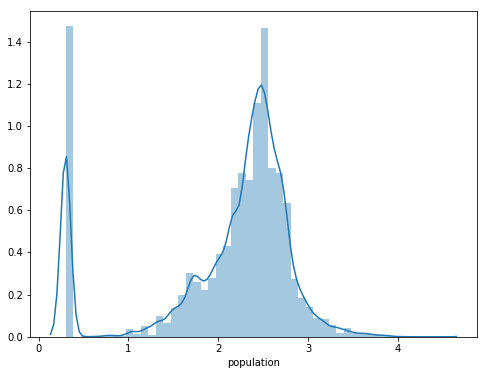

In [93]:
# plot new distrubition of populaton in log -> looks bad -> need log transformation!
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(np.log10(all_data.population + 1));

In [94]:
log_pop = np.log10(all_data.population + 1)
log_pop[log_pop < 0.3]

Series([], Name: population, dtype: float64)

### Outlier Analysis
Here our outlier analysis and treatment goes.

In [95]:
# Split data back to train and test from all_data
train = all_data[:len(train)]
test = all_data[len(train):]

In [96]:
train.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [97]:
# amout_tsh equal zero but well is functional and has enough water -> impute mean for population
train[(train.amount_tsh == 0) &
      (train.status_group == 'functional') &
      (train.quantity == 'enough')].amount_tsh.count()

12296

In [98]:
# Convert values to NaN first 
all_data.loc[(all_data.amount_tsh == 0) &
      (all_data.status_group == 'functional') &
      (all_data.quantity == 'enough'), 'amount_tsh'] = np.nan

In [99]:
# impute NaNs amount_tsh per subvillage and population
all_data.amount_tsh.fillna(all_data.groupby(['subvillage', 'population']).amount_tsh.transform('median'), inplace=True)

In [100]:
all_data.amount_tsh.isnull().sum()

5980

In [101]:
# impute NaNs amount_tsh per subvillage with same conditions
all_data.amount_tsh.fillna(all_data.groupby(['subvillage']).amount_tsh.transform('median'), inplace=True)

In [102]:
all_data.amount_tsh.isnull().sum()

3111

In [103]:
# impute NaNs amount_tsh per subvillage with same conditions
all_data.amount_tsh.fillna(all_data.groupby(['population']).amount_tsh.transform('median'), inplace=True)

In [104]:
all_data.amount_tsh.isnull().sum()

11

In [105]:
# impute NaNs amount_tsh per subvillage with same conditions
all_data.amount_tsh.fillna(all_data.groupby(['ward']).amount_tsh.transform('median'), inplace=True)

In [106]:
all_data.amount_tsh.isnull().sum()

0

## 6. Feature Engineering
1. Transformations
2. Binning
3. New features

### Transformations
#### Log
1. amount_tsh
2. population

We decided to use a log transformation because unbalanced distrubution of features, i.e. try to normalize them.

In [107]:
# Create new variable: amount_tsh_log
all_data['amount_tsh_log'] = np.log10(all_data.amount_tsh + 1)

# Create new variable: population_log
all_data['population_log'] = np.log10(all_data.population + 1)

### Binnning
Reclassify low value count levels to unknown / other:
1. management_group 
2. quality_group
3. extraction_type_class
4. scheme_management

First, create new variable with only 5 first chars, then Bin levels depening on value count:
1. funder
2. installer
3. subvillage
4. ward
5. lga
6. region
7. wpt_name

Binary binning:
1. wpt_name -> 2 levels: name, no name
2. scheme_name -> 2 levels: name, no name
3. payment_type -> 2 levels: pay, never_pay
4. payment_type_fixed -> 2 levels: fixed, not fixed
5. num_private -> 2 levels: number, no number

In [108]:
binning_table = {'management_group': {'other': 'unknown'},

                    'quality_group': {'fluoride': 'unknown',
                                       'colored': 'unknown',
                                      },

                    'extraction_type_class': {'rope pump': 'other',
                                             'wind-powered': 'other'
                                             },

                    'scheme_management': {'None': 'Other',
                                          'Trust': 'Other',
                                          'SWC': 'Other'
                                         }}

all_data = all_data.replace(binning_table)

In [109]:
# new variables with only five first characters
all_data['funder_5char'] = all_data.funder.str[:5]
all_data['installer_5char'] = all_data.installer.str[:5]

# Define function to bin value depending on value count
def binning_cat(x):
    if x <= 1:
        return 's1'
    elif (x>1) & (x<=10):
        return 's10'
    elif (x>10) & (x<=25):
        return 's25'
    elif (x>25) & (x<=50):
        return 's50'
    elif (x>50) & (x<=100):
        return 's100'
    elif (x>100) & (x<=250):
        return 's250'
    elif (x>250) & (x<=500):
        return 's500'
    elif (x>500) & (x<=1000):
        return 's1000'
    elif (x>1000):
        return 's+1000'

# funder_5char
# Create pivot_table with value count for funder_5char
funder_piv = all_data.pivot_table(index='funder_5char', values='quantity', aggfunc=len)

# Create datatable to populate with pivot table data along with binning values
# Keep unknown records as unknown
funder_df = pd.DataFrame()
funder_df['type'] = funder_piv.index
funder_df['count'] = funder_piv.values
funder_df['funder_size'] = \
    funder_df[funder_df.type != 'Unkno']['count'].apply(lambda x: binning_cat(x))
funder_df.loc[funder_df.type == 'Unkno', 'funder_size'] = 'unknown'
funder_map = dict(funder_df[['type', 'funder_size']].values)

# Create new variable funder_size based on binning
all_data['funder_size'] = all_data.funder_5char.map(funder_map)


# installer_5char
# Create pivot_table with value count for installer_5char
installer_piv = all_data.pivot_table(index='installer_5char', values='quantity', aggfunc=len)

# Create datatable to populate with pivot table data along with binning values
# Keep unknown records as unknown
installer_df = pd.DataFrame()
installer_df['type'] = installer_piv.index
installer_df['count'] = installer_piv.values
installer_df['installer_size'] = \
    installer_df[installer_df.type != 'Unkno']['count'].apply(lambda x: binning_cat(x))
installer_df.loc[installer_df.type == 'Unkno', 'installer_size'] = 'unknown'
installer_map = dict(installer_df[['type', 'installer_size']].values)

# Create new variable installer_size based on binning
all_data['installer_size'] = all_data.installer_5char.map(installer_map)


# subvillage
# Create pivot_table with value count for subvillage
subvillage_piv = all_data.pivot_table(index='subvillage', values='quantity', aggfunc=len)

# Create datatable to populate with pivot table data along with binning values
# Keep unknown records as unknown
subvillage_df = pd.DataFrame()
subvillage_df['type'] = subvillage_piv.index
subvillage_df['count'] = subvillage_piv.values
subvillage_df['subvillage_size'] = \
    subvillage_df[subvillage_df.type != 'Unkno']['count'].apply(lambda x: binning_cat(x))
subvillage_df.loc[subvillage_df.type == 'Unkno', 'subvillage_size'] = 'unknown'
subvillage_map = dict(subvillage_df[['type', 'subvillage_size']].values)

# Create new variable subvillage_size based on binning
all_data['subvillage_size'] = all_data.subvillage.map(subvillage_map)


# ward
# Create pivot_table with value count for ward
ward_piv = all_data.pivot_table(index='ward', values='quantity', aggfunc=len)

# Create datatable to populate with pivot table data along with binning values
# Keep unknown records as unknown
ward_df = pd.DataFrame()
ward_df['type'] = ward_piv.index
ward_df['count'] = ward_piv.values
ward_df['ward_size'] = \
    ward_df[ward_df.type != 'Unkno']['count'].apply(lambda x: binning_cat(x))
ward_df.loc[ward_df.type == 'Unkno', 'ward_size'] = 'unknown'
ward_map = dict(ward_df[['type', 'ward_size']].values)

# Create new variable ward_size based on binning
all_data['ward_size'] = all_data.ward.map(ward_map)


# lga
# Create pivot_table with value count for lga
lga_piv = all_data.pivot_table(index='lga', values='quantity', aggfunc=len)

# Create datatable to populate with pivot table data along with binning values
# Keep unknown records as unknown
lga_df = pd.DataFrame()
lga_df['type'] = lga_piv.index
lga_df['count'] = lga_piv.values
lga_df['lga_size'] = \
    lga_df[lga_df.type != 'Unkno']['count'].apply(lambda x: binning_cat(x))
lga_df.loc[lga_df.type == 'Unkno', 'lga_size'] = 'unknown'
lga_map = dict(lga_df[['type', 'lga_size']].values)

# Create new variable lga_size based on binning
all_data['lga_size'] = all_data.lga.map(lga_map)


# wpt_name
# Create pivot_table with value count for wpt_name
wpt_name_piv = all_data.pivot_table(index='wpt_name', values='quantity', aggfunc=len)

# Create datatable to populate with pivot table data along with binning values
# Keep unknown records as unknown
wpt_name_df = pd.DataFrame()
wpt_name_df['type'] = wpt_name_piv.index
wpt_name_df['count'] = wpt_name_piv.values
wpt_name_df['wpt_name_size'] = \
    wpt_name_df[wpt_name_df.type != 'Unkno']['count'].apply(lambda x: binning_cat(x))
wpt_name_df.loc[wpt_name_df.type == 'Unkno', 'wpt_name_size'] = 'unknown'
wpt_name_map = dict(wpt_name_df[['type', 'wpt_name_size']].values)

# Create new variable wpt_name_size based on binning
all_data['wpt_name_size'] = all_data.wpt_name.map(wpt_name_map)

In [110]:
# Binary binning:
# 1. wpt_name -> 2 levels: name, no name
all_data['wpt_name_bin'] = all_data['wpt_name']
all_data.loc[(all_data.wpt_name_bin != 'none'), 'wpt_name_bin'] = 'name'

# 2. scheme_name -> 2 levels: name, no name
all_data['scheme_name_bin'] = all_data['scheme_name']
all_data.loc[(all_data.scheme_name_bin != 'None'), 'scheme_name_bin'] = 'Name'

# 3. payment_type -> 2 levels: pay, never_pay
all_data['payment_type_bin'] = all_data['payment_type']
all_data.loc[(all_data.payment_type_bin != 'never pay'), 'payment_type_bin'] = 'pay'

# 4. payment_type_fixed -> 2 levels: fixed, not fixed
all_data['payment_type_fixed'] = all_data['payment_type']
all_data.loc[(all_data.payment_type_fixed == 'monthly') | (all_data.payment_type_fixed == 'annually'),
             'payment_type_fixed'] = 'fixed'
all_data.loc[(all_data.payment_type_fixed != 'fixed'), 'payment_type_fixed'] = 'not fixed'

# 5. num_private -> 2 levels: number, no number
all_data['num_private_bin'] = all_data['num_private']
all_data.loc[(all_data.num_private_bin != 0), 'num_private_bin'] = 'number'
all_data.loc[(all_data.num_private_bin != 'number'), 'num_private_bin'] = 'no number'

In [111]:
# Further Funder binning
all_data['funder_simple'] = all_data['funder'].str.lower()
# foregin gov
all_data['funder_simple'].replace(['danida', 'a/co germany', 'belgian', 'british', 'england', 'german', 'germany',
         'china', 'egypt', 'european union', 'finland', 'japan', 'france', 'greec',
         'netherlands', 'holland', 'holand', 'nethe', 'nethalan', 'netherla', 'netherlands',
         'iran', 'irish', 'islam','italy', 'u.s.a', 'usa', 'usaid', 'swiss', 'swedish','korea', 'niger',
                                   'germany republi'], 'f_gov', inplace=True)

# NGOs
all_data['funder_simple'].replace(['world bank', 'ngo', "ngos", "un","un hhabitat", "un/wfp", "undp", "undp/aict", "undp/ilo", "unesco",                        
       "unhcr", "unhcr/government", "unice", "unice/ cspd", "unicef", "unicef/ csp", "unicef/african muslim agency", 
       "unicef/central", "unicef/cspd", "uniceg", "unicet", "unicrf", "uniseg", "unp/aict", "wwf", "wfp", "oxfam",
                                   "world vision", "rc church", "wateraid", ], 'ngo', inplace=True)

# local government
all_data['funder_simple'].replace(['government of tanzania', 'district council', 'ministry of water'],
                                  'l_gov', inplace=True)

# others
all_data.loc[(all_data.funder_simple != 'f_gov') &
             (all_data.funder_simple != 'ngo') &
             (all_data.funder_simple != 'l_gov'), 'funder_simple'] = 'unknown'
                                  

### New Variables
Create the following new variables:
1. recored_year -> YY from recorded_date
2. recored_month -> MM from recorded_date
3. age -> construction year - recored_year
4. latlong -> round(latitude + longitude

In [112]:
# Recored_date -> YY
all_data['recorded_year'] = all_data.date_recorded.dt.year

# Recored_date -> MM
all_data['recorded_month'] = all_data.date_recorded.dt.month

# Age = Recored_date - construction_year
all_data['well_age'] = all_data.recorded_year-all_data.construction_year

# Construction decade
all_data['construction_decade'] = all_data.construction_year
all_data.loc[(all_data.construction_decade > 1959) & (all_data.construction_decade < 1970),
             'construction_decade'] = 1960
all_data.loc[(all_data.construction_decade > 1969) & (all_data.construction_decade < 1980),
             'construction_decade'] = 1970
all_data.loc[(all_data.construction_decade > 1979) & (all_data.construction_decade < 1990),
             'construction_decade'] = 1980
all_data.loc[(all_data.construction_decade > 1989) & (all_data.construction_decade < 2000),
             'construction_decade'] = 1990
all_data.loc[(all_data.construction_decade > 1999) & (all_data.construction_decade < 2010),
             'construction_decade'] = 2000
all_data.loc[(all_data.construction_decade > 2009),
             'construction_decade'] = 2010

# Simple Latitude 
all_data['lat_simple'] = round(all_data.latitude, 1)

# Simple Longitude
all_data['long_simple'] = round(all_data.longitude, 1)

## 7. Feature selection

Drop the following features:
1. num_private -> replaced by engineered feature
2. payment -> same as payment_type
3. extraction_type -> same as extraction_class_group
4. extraction_type_group -> same as extraction_class_group
5. quantity_group -> same as quantity
6. water_quality -> same as quality_group but more levels
7. source -> same as source_type but with unknowns
8. source_class -> less granular than source_type, only 3 levels
9. waterpoint_type -> same as waterpoint_type_groupe but with more levels
10. recorded_by -> only one level
11. management -> same as scheme_management but messier text
12. region_code -> prefer names
13. district_code -> prefer names
14. lga -> replaced by engineered feature
15. ward -> replaced by engineered feature
16. subvillage -> replaced by engineered feature
17. funder -> replaced by engineered feature
18. installer -> replaced by engineered feature
19. scheme_name -> replaced by engineered feature
20. wpt_name -> replaced by engineered feature
21. funder_5char -> replaced by engineered feature
22. installer_5char -> replaced by engineered feature
23. construction_year -> replaced by engineered feature
24. date_recorded -> replaced by engineered feature
25. population -> replaced by engineered feature
26. latitude -> replaced by engineered feature
27. longitude -> replaced by engineered feature
28. amount_tsh -> replaced by engineered feature
29. latlong -> too granular

In [113]:
# Define features to drop
drop_features = ['num_private', 'payment', 'extraction_type', 'extraction_type_group', 'quantity_group',
                 'water_quality', 'source', 'source_class', 'waterpoint_type', 'recorded_by', 'management',
                 'region_code', 'district_code', 'lga', 'ward', 'subvillage', 'funder', 'installer', 'scheme_name',
                 'wpt_name', 'funder_5char', 'installer_5char', 'construction_year', 'date_recorded', 'population',
                 'latitude', 'longitude', 'amount_tsh', 'latlong']

# Drop features
all_data.drop(drop_features, axis=1, inplace=True)

# Remaining nummerical features
all_data.describe()

,gps_height,amount_tsh_log,population_log,recorded_year,recorded_month,well_age,construction_decade,lat_simple,long_simple
count,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,1038.288904,0.727294,2.108935,2011.918559,4.381347,15.057449,1992.223973,-5.843036,35.121518
std,539.430995,1.159638,0.781984,0.960299,3.031019,10.694158,10.902305,2.783183,2.581601
min,-90.000000,0.000000,0.301030,2001.000000,1.000000,0.000000,1960.000000,-11.600000,29.600000
25%,687.500000,0.000000,1.908485,2011.000000,2.000000,6.500000,1990.000000,-8.500000,33.300000
50%,1115.000000,0.000000,2.371953,2012.000000,3.000000,13.267677,1990.000000,-5.100000,34.900000
75%,1420.000000,1.491362,2.581423,2013.000000,7.000000,20.273147,2000.000000,-3.400000,37.200000
max,2777.000000,5.544069,4.484314,2013.000000,12.000000,53.000000,2010.000000,-1.100000,40.300000


In [114]:
# Remaining catergorical features
all_cat_vars = all_data.select_dtypes(include=['object'])
all_cat_vars.describe()

,basin,extraction_type_class,management_group,payment_type,permit,public_meeting,quality_group,quantity,region,scheme_management,source_type,status_group,waterpoint_type_group,funder_size,installer_size,subvillage_size,ward_size,lga_size,wpt_name_size,wpt_name_bin,scheme_name_bin,payment_type_bin,payment_type_fixed,num_private_bin,funder_simple
count,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,59400,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
unique,9,5,4,7,3,3,4,5,21,10,7,3,6,10,10,9,7,7,9,2,2,2,2,2,4
top,Lake Victoria,gravity,user-group,never pay,True,True,good,enough,Iringa,VWC,spring,functional,communal standpipe,s+1000,s+1000,s10,s100,s1000,s1,name,Name,pay,not fixed,no number,unknown
freq,12871,33263,65538,31712,48606,63749,63505,41522,6599,45917,21216,32259,43239,34325,36404,39576,24400,30578,39882,69810,73456,42538,59283,73299,48609


## Data Resampling (not used atm)
Given there is inbalance of the three different targets, need repairs only represent 7% of data, could it improve to resample some of the data and expand the training set to achieve better predictions? 


In [115]:
# import library
from sklearn.utils import resample

In [116]:
# Count majority and minority classes
functional_count = all_data[all_data.status_group == 'functional'].status_group.count()
non_functional_count = all_data[all_data.status_group == 'non functional'].status_group.count()
repairs_count = all_data[all_data.status_group == 'functional needs repair'].status_group.count()

In [117]:
# Separate majority and minority classes
df_majority = all_data[all_data.status_group == 'functional']
non_functional_minority = all_data[all_data.status_group == 'non functional']
repairs_minority = all_data[all_data.status_group == 'functional needs repair']

In [118]:
# Upsample minority class
non_functional_upsampled = resample(non_functional_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=functional_count,    # to match majority class
                                 random_state=42) # reproducible results

reparis_upsampled = resample(repairs_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=functional_count,    # to match majority class
                                 random_state=42) # reproducible results

In [119]:
# Combine majority class with upsampled minority class
new_data = pd.concat([df_majority, non_functional_upsampled, reparis_upsampled])

# Display new class counts
new_data.status_group.value_counts()

non functional             32259
functional                 32259
functional needs repair    32259
Name: status_group, dtype: int64

## 8. Modelling Prepartation

1. Drop status_group from all_data
2. One-hot encoding - Create dummy variables for all categorical features.
3. Split all_data back into train_data and test_data
4. Factorize training labels -> numerical representation
5. Write clean data to csv.

In [120]:
# Drop status_group
all_data.drop('status_group', axis=1, inplace=True)

# One-hot encoding: Create dummies for all_data
all_data = pd.get_dummies(all_data)

# Split data back to train and test from all_data (split based on empty status_group)
train_data = all_data[:len(train)]
test_data = all_data[len(train):]

In [121]:
# Factorize train_labels
labels = pd.factorize(train_labels.status_group)[0]
labels

array([0, 0, 0, ..., 0, 0, 0])

In [122]:
# Write cleaned data to csv
train_data.to_csv('data/train_clean.csv', sep=',')
test_data.to_csv('data/test_clean.csv', sep=',')